<a href="https://colab.research.google.com/github/MufadhaTiohandra/skripsi/blob/smote_without_pipeline/modeling_noCV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### **DO SEMI-SUPERVISED LEARNING**

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/MyDrive/Colab Notebooks/Skripsi

Mounted at /content/drive/
/content/drive/MyDrive/Colab Notebooks/Skripsi


In [ ]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import matplotlib.pyplot as plt
import seaborn as sns
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
list_dir = os.listdir()

In [ ]:
# pre loading all data
generate_file = [file for file in list_dir
                 if file.__contains__('imputed')]
df = pd.DataFrame()
for i,file in enumerate(generate_file):
   temp_df = pd.read_csv(file)
   df = pd.concat([df, temp_df], ignore_index=True)

In [ ]:
train_df = df[~df['sii'].isna()]
X_train, X_test, y_train, y_test = \
train_test_split(
    train_df.drop(columns=['sii']),
    train_df['sii'],
    test_size=0.2,
    random_state=RANDOM_SEED,
    stratify=train_df['sii']
)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Apply SMOTE to the scaled training data
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=RANDOM_SEED)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

model = SVC(kernel='rbf', C=1, random_state=RANDOM_SEED)
model.fit(X_train_resampled, y_train_resampled) # Fit on resampled data
y_pred = model.predict(X_test) # Predict on scaled (but not resampled) test data
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      0.96      0.98       319
         1.0       0.89      0.98      0.93       146
         2.0       0.92      0.96      0.94        76
         3.0       1.00      0.57      0.73         7

    accuracy                           0.96       548
   macro avg       0.95      0.87      0.90       548
weighted avg       0.96      0.96      0.96       548

[[305  14   0   0]
 [  0 143   3   0]
 [  0   3  73   0]
 [  0   0   3   4]]


In [ ]:
new_sii = df[df['sii'].isna()].drop(columns=['sii'])
new_sii_scaled = scaler.transform(new_sii)
new_sii_pred = model.predict(new_sii_scaled)
new_sii['sii'] = new_sii_pred

In [ ]:
df = pd.concat([train_df, new_sii], ignore_index=True)
df.isna().sum()

,0
Basic_Demos-Age,0
Basic_Demos-Sex,0
Physical-BMI,0
IAT-IAT_01,0
IAT-IAT_02,0
IAT-IAT_03,0
IAT-IAT_04,0
IAT-IAT_05,0
IAT-IAT_06,0
IAT-IAT_07,0


In [ ]:
X_train, X_test, y_train, y_test = \
train_test_split(
    df.drop(columns=['sii']),
    df['sii'],
    test_size=0.2,
    random_state=RANDOM_SEED,
    stratify=df['sii']
)

In [ ]:
# Check class distribution before oversampling
print("Class distribution before oversampling:")
print(y_train.value_counts().sort_index())
print("\nClass distribution percentages:")
print(y_train.value_counts(normalize=True).sort_index() * 100)

Class distribution before oversampling:
sii
0.0    2143
1.0     695
2.0     303
3.0      27
Name: count, dtype: int64

Class distribution percentages:
sii
0.0    67.645202
1.0    21.938131
2.0     9.564394
3.0     0.852273
Name: proportion, dtype: float64


#### **Train Model with SVM**

#### **Create Pipeline with SMOTE for Oversampling**
This pipeline ensures no data leakage during cross-validation by applying SMOTE only on training folds.

In [ ]:
# Scale the data first
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply SMOTE to the scaled training data
smote = SMOTE(random_state=RANDOM_SEED)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

print("Class distribution after SMOTE:")
print(pd.Series(y_train_resampled).value_counts().sort_index())

# Define parameter grid for GridSearchCV
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

# Use GridSearchCV with the resampled data
grid = GridSearchCV(
    SVC(random_state=RANDOM_SEED, probability=True),
    param_grid,
    cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_SEED),
    n_jobs=-1,
    verbose=2,
    scoring='accuracy'
)

# Fit on the resampled training data
grid.fit(X_train_resampled, y_train_resampled)

print("Best parameters found: ", grid.best_params_)
best_model = grid.best_estimator_
print("Best cross-validation score: {:.4f}".format(grid.best_score_))
print("Training set score: {:.4f}".format(best_model.score(X_train_resampled, y_train_resampled)))
print("Test set score: {:.4f}".format(best_model.score(X_test_scaled, y_test)))

Class distribution after SMOTE:
sii
0.0    2143
1.0    2143
2.0    2143
3.0    2143
Name: count, dtype: int64
Fitting 10 folds for each of 24 candidates, totalling 240 fits
Best parameters found:  {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}
Best cross-validation score: 0.9944
Training set score: 0.9999
Test set score: 0.9672


In [ ]:
# Train the best model on entire resampled training set
model_svm = best_model
y_pred = model_svm.predict(X_test_scaled)
y_train_pred = model_svm.predict(X_train_resampled)

print('Training Accuracy Score for SVM with SMOTE: {:.4f}'.format(accuracy_score(y_train_resampled, y_train_pred)))
print('Testing Accuracy Score for SVM with SMOTE: {:.4f}'.format(accuracy_score(y_test, y_pred)))
print("\nClassification Report on Test Set:")
print(classification_report(y_test, y_pred))

Training Accuracy Score for SVM with SMOTE: 0.9999
Testing Accuracy Score for SVM with SMOTE: 0.9672

Classification Report on Test Set:
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       536
         1.0       0.94      0.93      0.93       174
         2.0       0.89      0.93      0.91        75
         3.0       1.00      0.57      0.73         7

    accuracy                           0.97       792
   macro avg       0.95      0.86      0.89       792
weighted avg       0.97      0.97      0.97       792



In [ ]:
# Perform AdaBoost with cross validation using SMOTE applied once
# skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_SEED)
# accuracy_score_ada = []
# from sklearn.ensemble import AdaBoostClassifier

# # Extract the best SVC parameters from grid search
# best_svc_params = grid.best_params_

# # Perform cross-validation on the resampled data
# for train_index, test_index in skf.split(X_train_resampled, y_train_resampled):
#     X_tr, X_val = X_train_resampled[train_index], X_train_resampled[test_index]
#     y_tr, y_val = y_train_resampled[train_index], y_train_resampled[test_index]

#     ada_temp = AdaBoostClassifier(
#         estimator=SVC(**best_svc_params, random_state=RANDOM_SEED, probability=True),
#         n_estimators=100,
#         random_state=RANDOM_SEED,
#         learning_rate=0.1
#     )
#     ada_temp.fit(X_tr, y_tr)
#     score = ada_temp.score(X_val, y_val)
#     accuracy_score_ada.append(score)

# print("Cross-validation Accuracy scores:", [f"{score:.4f}" for score in accuracy_score_ada])
# print("Mean CV Accuracy: {:.4f} (+/- {:.4f})".format(np.mean(accuracy_score_ada), np.std(accuracy_score_ada)))

In [ ]:
# Training for the entire train dataset after checking with cross-validation
# Extract the best SVC parameters from grid search
from sklearn.ensemble import AdaBoostClassifier
best_svc_params = grid.best_params_

ada_model = AdaBoostClassifier(
    estimator=SVC(**best_svc_params, random_state=RANDOM_SEED, probability=True),
    n_estimators=100,
    random_state=RANDOM_SEED,
    learning_rate=0.1
)

ada_model.fit(X_train_resampled, y_train_resampled)
y_ada_pred = ada_model.predict(X_test_scaled)
print('Training score AdaBoost with SMOTE: {:.4f}'.format(ada_model.score(X_train_resampled, y_train_resampled)))
print('Test score AdaBoost with SMOTE: {:.4f}'.format(ada_model.score(X_test_scaled, y_test)))
print("\nClassification Report on Test Set:")
print(classification_report(y_test, y_ada_pred))

Training score AdaBoost with SMOTE: 0.9881
Test score AdaBoost with SMOTE: 0.9558

Classification Report on Test Set:
              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98       536
         1.0       0.87      0.96      0.91       174
         2.0       0.99      0.89      0.94        75
         3.0       0.67      0.57      0.62         7

    accuracy                           0.96       792
   macro avg       0.88      0.85      0.86       792
weighted avg       0.96      0.96      0.96       792



#### **Model Evaluation**

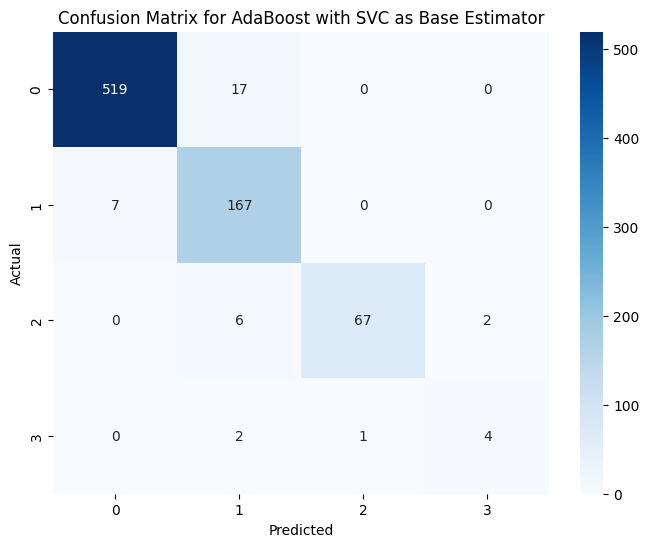

In [ ]:
cm_ada = confusion_matrix(y_test, ada_model.predict(X_test_scaled))
plt.figure(figsize=(8,6))
sns.heatmap(cm_ada, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for AdaBoost with SVC as Base Estimator')
plt.show()

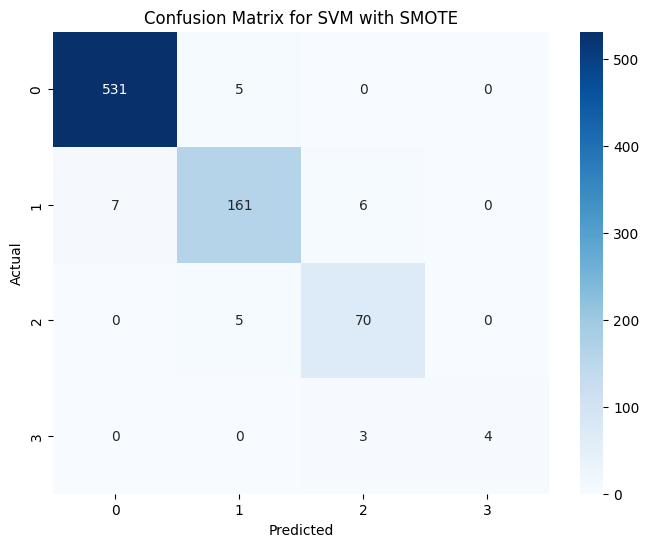

In [ ]:
# Confusion matrix for SVM with SMOTE
y_pred = best_model.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for SVM with SMOTE')
plt.show()

#### **ROC-AUC (OVR & OVO)**

In [ ]:
# Get probability predictions from both models
y_prob_svc = best_model.predict_proba(X_test_scaled)
y_prob_ada = ada_model.predict_proba(X_test_scaled)

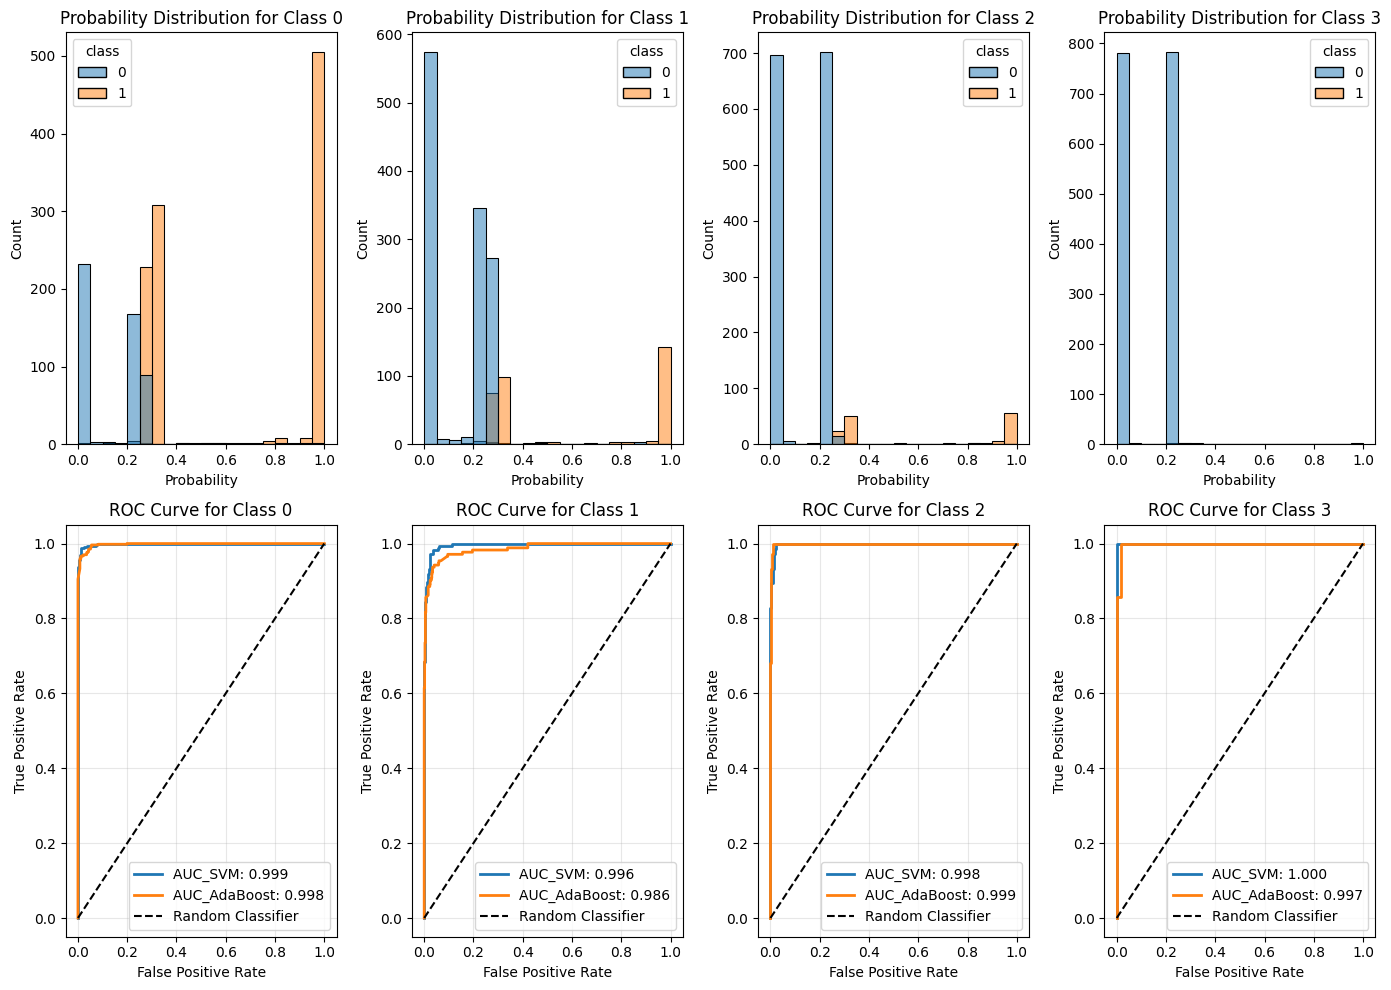

ROC-AUC Scores (One-vs-Rest):
Class 0 (SVM): 0.9988
Class 1 (SVM): 0.9960
Class 2 (SVM): 0.9983
Class 3 (SVM): 0.9998
Class 0 (AdaBoost): 0.9978
Class 1 (AdaBoost): 0.9859
Class 2 (AdaBoost): 0.9990
Class 3 (AdaBoost): 0.9967


In [ ]:
#### **ROC-AUC (OVR & OVO)**

from sklearn.metrics import roc_curve, auc
import pandas as pd

class_list = [0, 1, 2, 3]

plt.figure(figsize=(14, 10))
bins = [i/20 for i in range(20)] + [1.0]
roc_auc_ovr_svm = {}
roc_auc_ovr_ada = {}

# Convert y_test to numpy array for consistency
y_test_array = np.array(y_test)

for i in range(len(class_list)):
    c = class_list[i]

    # Create DataFrame for plotting - X_test is already original unscaled data
    df_aux = pd.DataFrame()
    df_aux['class'] = [1 if label == c else 0 for label in y_test_array]
    df_aux['prob_svm'] = y_prob_svc[:, i]
    df_aux['prob_ada'] = y_prob_ada[:, i]
    df_aux = df_aux.reset_index(drop=True)

    # Plot histogram
    ax = plt.subplot(2, 4, i+1)
    sns.histplot(data=df_aux, x='prob_svm', hue='class', color='b', ax=ax, bins=bins)
    sns.histplot(data=df_aux, x='prob_ada', hue='class', color='r', ax=ax, bins=bins)
    ax.set_title(f'Probability Distribution for Class {c}')
    ax.set_xlabel('Probability')

    # Plot ROC curve
    ax_bottom = plt.subplot(2, 4, i+5)
    fpr_svm, tpr_svm, _ = roc_curve(df_aux['class'], df_aux['prob_svm'])
    fpr_ada, tpr_ada, _ = roc_curve(df_aux['class'], df_aux['prob_ada'])
    roc_auc_svm = auc(fpr_svm, tpr_svm)
    roc_auc_ada = auc(fpr_ada, tpr_ada)
    roc_auc_ovr_svm[c] = roc_auc_svm
    roc_auc_ovr_ada[c] = roc_auc_ada

    ax_bottom.plot(fpr_svm, tpr_svm, label=f'AUC_SVM: {roc_auc_svm:.3f}', linewidth=2)
    ax_bottom.plot(fpr_ada, tpr_ada, label=f'AUC_AdaBoost: {roc_auc_ada:.3f}', linewidth=2)
    ax_bottom.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
    ax_bottom.set_xlabel('False Positive Rate')
    ax_bottom.set_ylabel('True Positive Rate')
    ax_bottom.set_title(f'ROC Curve for Class {c}')
    ax_bottom.legend()
    ax_bottom.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print AUC scores
print("ROC-AUC Scores (One-vs-Rest):")
for label, auc_score in roc_auc_ovr_svm.items():
    print(f"Class {label} (SVM): {auc_score:.4f}")
for label, auc_score in roc_auc_ovr_ada.items():
    print(f"Class {label} (AdaBoost): {auc_score:.4f}")

In [ ]:
# make combinations of class_list for OVO
combine_labels = []
for i in range(len(class_list)):
    for j in range(i+1, len(class_list)):
        combine_labels.append([class_list[i], class_list[j]])
        combine_labels.append([class_list[j], class_list[i]])


In [ ]:
combine_labels_1 = combine_labels[:6]
combine_labels_2 = combine_labels[6:]

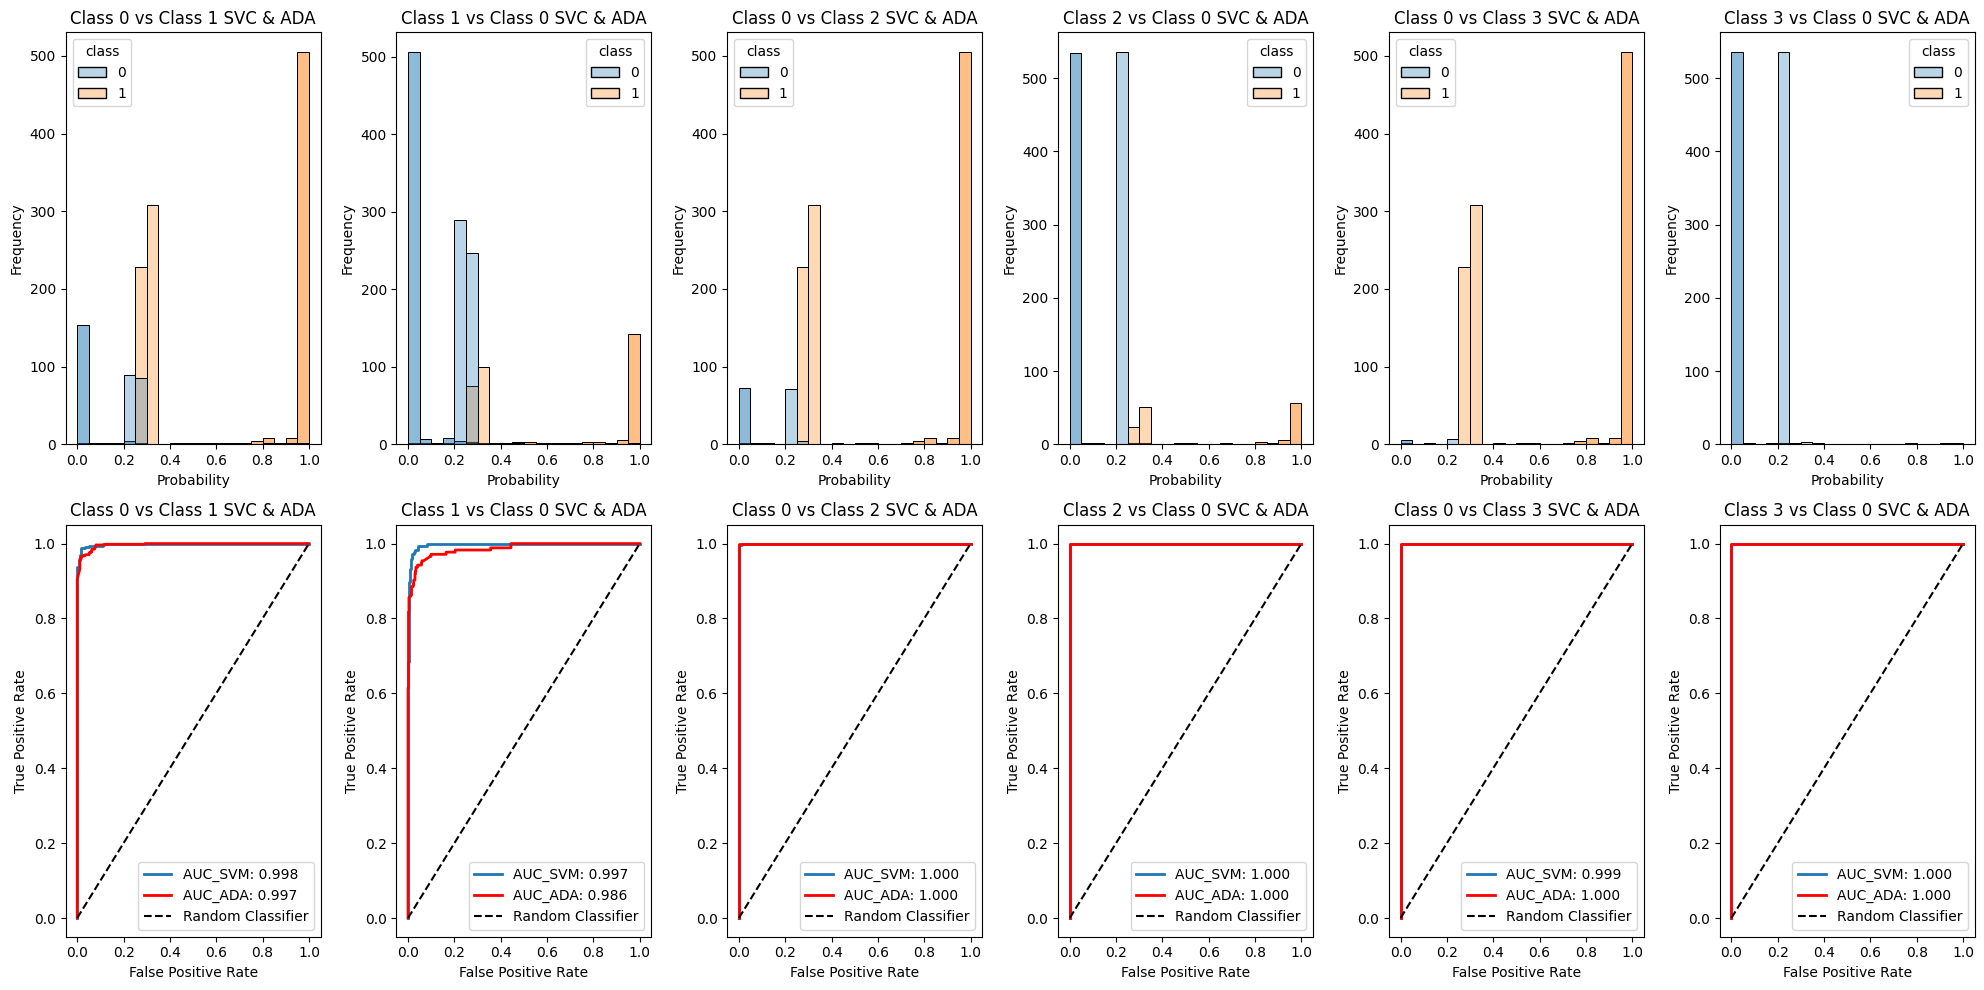

In [ ]:
bins = [i/20 for i in range(20)] + [1.0]
roc_auc_ovo_svm = {}
roc_auc_ovo_ada = {}
plt.figure(figsize=(20, 10))
for i in range(len(combine_labels_1)):
    labels = combine_labels_1[i]
    df_aux = pd.DataFrame()
    c1 = labels[0]
    c2 = labels[1]
    title = f'Class {c1} vs Class {c2}'
    c1_index = class_list.index(c1)

    df_aux['class'] = y_test
    df_aux['prob_svc'] = y_prob_svc[:, c1_index]
    df_aux['prob_ada'] = y_prob_ada[:, c1_index]

    # slicing df aux just for c1 and c2
    df_aux = df_aux[(df_aux['class'] == c1) | (df_aux['class'] == c2)]
    df_aux['class'] = [1 if label == c1 else 0 for label in df_aux['class']]
    df_aux = df_aux.reset_index(drop=True)

    # plot histogram
    ax = plt.subplot(2, 6, i+1)
    sns.histplot(data=df_aux, x='prob_svc', hue='class', color='b', ax=ax, bins=bins)
    sns.histplot(data=df_aux, x='prob_ada', hue='class', color='r', ax=ax, bins=bins, alpha=0.3)
    ax.set_title(f'{title} SVC & ADA')
    ax.set_xlabel('Probability')
    ax.set_ylabel('Frequency')

    # plot ROC curve
    ax_bottom = plt.subplot(2, 6, i+7)
    fpr_svc, tpr_svc, _ = roc_curve(df_aux['class'], df_aux['prob_svc'])
    fpr_ada, tpr_ada, _ = roc_curve(df_aux['class'], df_aux['prob_ada'])
    roc_auc_svm = auc(fpr_svc, tpr_svc)
    roc_auc_ovo_svm[title] = roc_auc_svm
    roc_auc_ada = auc(fpr_ada, tpr_ada)
    roc_auc_ovo_ada[title] = roc_auc_ada
    ax_bottom.plot(fpr_svc, tpr_svc, label=f'AUC_SVM: {roc_auc_svm:.3f}', linewidth=2)
    ax_bottom.plot(fpr_ada, tpr_ada, label=f'AUC_ADA: {roc_auc_ada:.3f}', linewidth=2,  color='r')
    ax_bottom.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
    ax_bottom.set_xlabel('False Positive Rate')
    ax_bottom.set_ylabel('True Positive Rate')
    ax_bottom.set_title(f'{title} SVC & ADA')
    ax_bottom.legend()

plt.tight_layout()
plt.show()

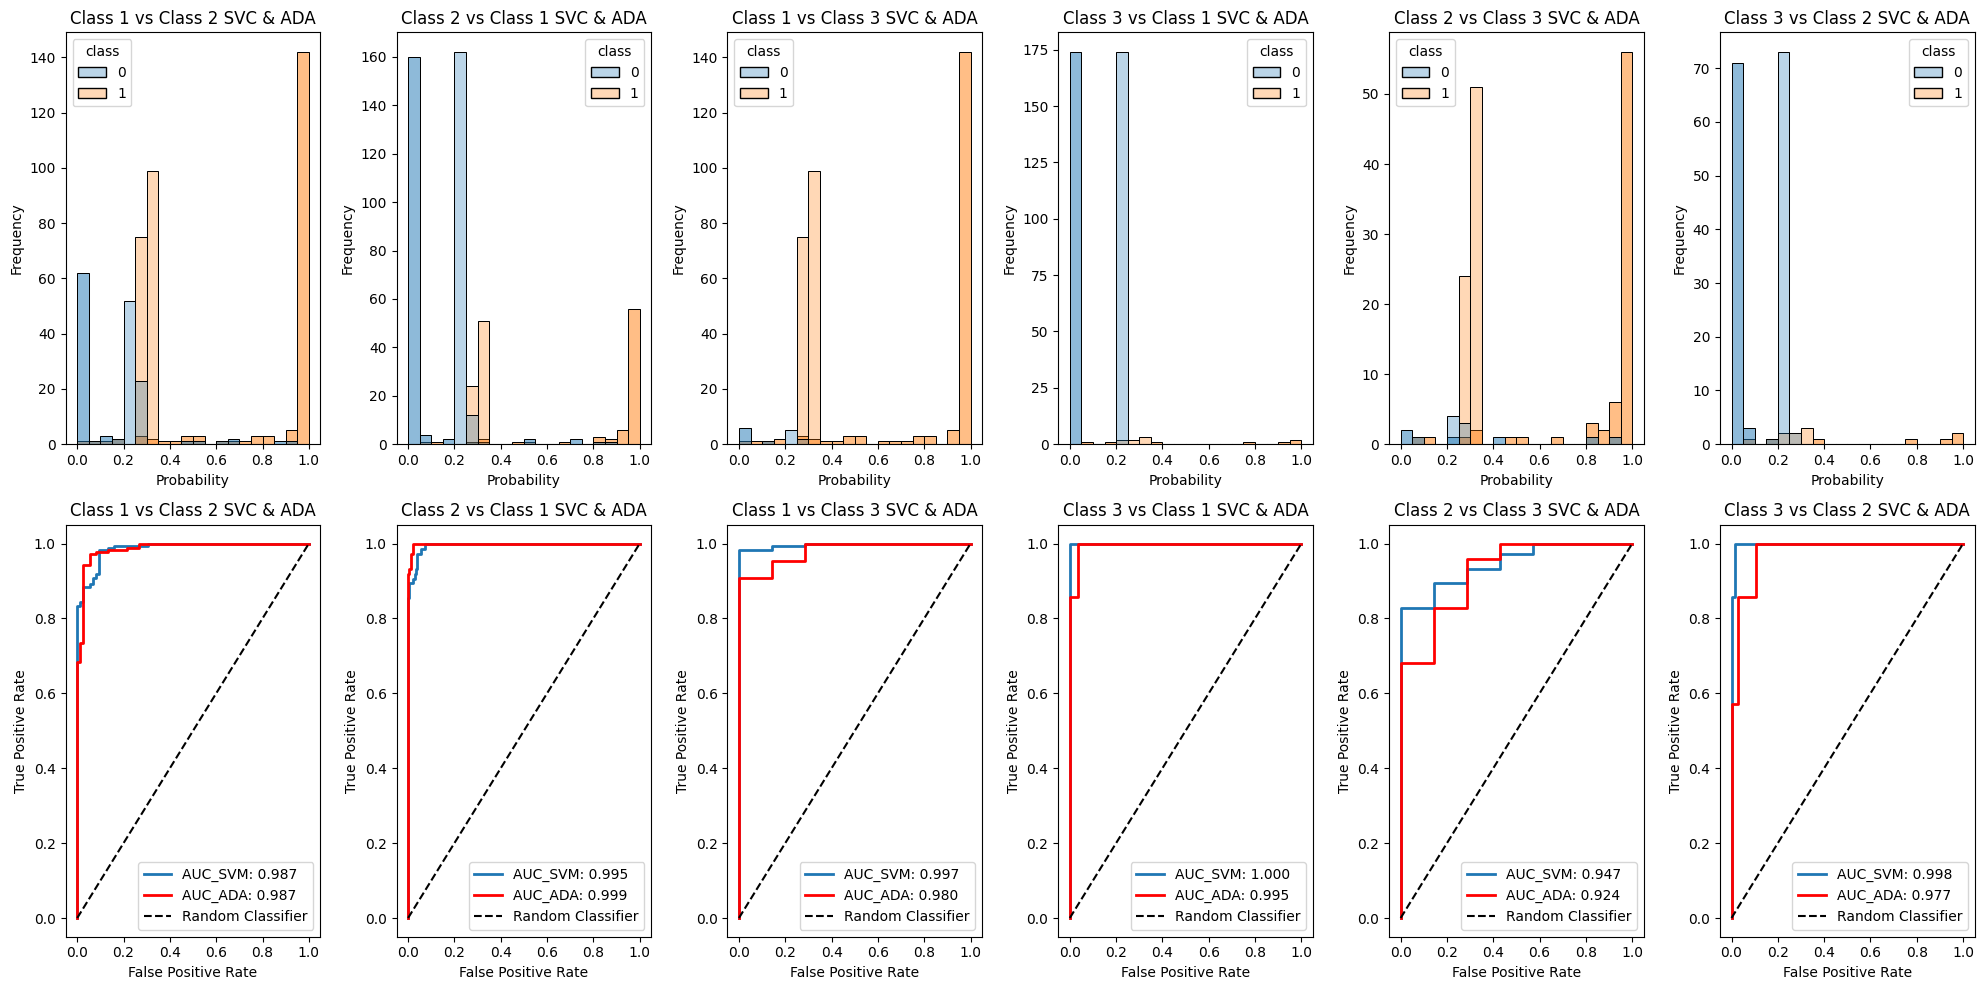

Average ROC-AUC Scores (One-vs-One) SVC:
Mean: 0.9981, Std: 0.0000
Average ROC-AUC Scores (One-vs-One) ADA:
Mean: 0.9771, Std: 0.0000


In [ ]:
bins = [i/20 for i in range(20)] + [1.0]
plt.figure(figsize=(20, 10))
for i in range(len(combine_labels_2)):
    labels = combine_labels_2[i]
    df_aux = pd.DataFrame()
    c1 = labels[0]
    c2 = labels[1]
    title = f'Class {c1} vs Class {c2}'
    c1_index = class_list.index(c1)

    df_aux['class'] = y_test
    df_aux['prob_svc'] = y_prob_svc[:, c1_index]
    df_aux['prob_ada'] = y_prob_ada[:, c1_index]

    # slicing df aux just for c1 and c2
    df_aux = df_aux[(df_aux['class'] == c1) | (df_aux['class'] == c2)]
    df_aux['class'] = [1 if label == c1 else 0 for label in df_aux['class']]
    df_aux = df_aux.reset_index(drop=True)

    # plot histogram
    ax = plt.subplot(2, 6, i+1)
    sns.histplot(data=df_aux, x='prob_svc', hue='class', color='b', ax=ax, bins=bins)
    sns.histplot(data=df_aux, x='prob_ada', hue='class', color='r', ax=ax, bins=bins, alpha=0.3)
    ax.set_title(f'{title} SVC & ADA')
    ax.set_xlabel('Probability')
    ax.set_ylabel('Frequency')

    # plot ROC curve
    ax_bottom = plt.subplot(2, 6, i+7)
    fpr_svc, tpr_svc, _ = roc_curve(df_aux['class'], df_aux['prob_svc'])
    fpr_ada, tpr_ada, _ = roc_curve(df_aux['class'], df_aux['prob_ada'])
    roc_auc_svm = auc(fpr_svc, tpr_svc)
    roc_auc_ovo_svm[title] = roc_auc_svm
    roc_auc_ada = auc(fpr_ada, tpr_ada)
    roc_auc_ovo_ada[title] = roc_auc_ada
    ax_bottom.plot(fpr_svc, tpr_svc, label=f'AUC_SVM: {roc_auc_svm:.3f}', linewidth=2)
    ax_bottom.plot(fpr_ada, tpr_ada, label=f'AUC_ADA: {roc_auc_ada:.3f}', linewidth=2,  color='r')
    ax_bottom.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
    ax_bottom.set_xlabel('False Positive Rate')
    ax_bottom.set_ylabel('True Positive Rate')
    ax_bottom.set_title(f'{title} SVC & ADA')
    ax_bottom.legend()
plt.tight_layout()
plt.show()


for key, auc_score in roc_auc_ovo_svm.items():
    dummy_list = []
    dummy_list.append(auc_score)
print("Average ROC-AUC Scores (One-vs-One) SVC:")
print(f"Mean: {np.mean(dummy_list):.4f}, Std: {np.std(dummy_list):.4f}")

for key, auc_score in roc_auc_ovo_ada.items():
    dummy_list = []
    dummy_list.append(auc_score)
print("Average ROC-AUC Scores (One-vs-One) ADA:")
print(f"Mean: {np.mean(dummy_list):.4f}, Std: {np.std(dummy_list):.4f}")


In [ ]:
import joblib
# Save the models and scaler
joblib.dump(ada_model, 'ada_model_noCV.pkl')
joblib.dump(best_model, 'svm_model_noCV.pkl')
joblib.dump(scaler, 'scaler.pkl')
print("Models and scaler saved successfully!")
print("Note: You'll need to load the scaler and apply it to new data before prediction")

Models and scaler saved successfully!
Note: You'll need to load the scaler and apply it to new data before prediction
